## Assessment of the impact of OCR on linguistic tasks

In particular, in this notebook we're looking at:
- Part-of-speech tagging accuracy (fine- and coarse-grained)
- Named entity recognition accuracy (matching type, matching type and IOB-tag)
    - Persons: f-score (by quality band)
    - Geopolitical entities: f-score (by quality band)
    - Dates: f-score (by quality band)
- Dependency parsing

In [1]:
import pathlib
import spacy
import pandas as pd
import numpy as np
import collections
import re
import ast
import matplotlib.pyplot as plt

import warnings; warnings.simplefilter('ignore')

import seaborn as sns
sns.set(style="white")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

In [2]:
nlp = spacy.load('en_core_web_lg')

### Get sample and apply Spacy

Obtain a sample of the data for which we have the same number of articles from each quality band. Apply Spacy to the OCR and the human-corrected texts, and save the new dataframe.

In [3]:
spacyfile = pathlib.Path("trove_subsample_aligned_spacy.pkl")
trovedf = pd.DataFrame()
sampledf_band1 = pd.DataFrame()
sampledf_band2 = pd.DataFrame()
sampledf_band3 = pd.DataFrame()
sampledf_band4 = pd.DataFrame()
sampledf = pd.DataFrame()
if not spacyfile.exists():
    trovedf = pd.read_pickle("trove_subsample_aligned.pkl")
    sampledf_band1 = trovedf[trovedf['quality_band'] == 1].sample(950)
    sampledf_band2 = trovedf[trovedf['quality_band'] == 2].sample(950)
    sampledf_band3 = trovedf[trovedf['quality_band'] == 3].sample(950)
    sampledf_band4 = trovedf[trovedf['quality_band'] == 4].sample(950)
    sampledf = pd.concat([sampledf_band1, sampledf_band2, sampledf_band3, sampledf_band4])
    sampledf['spacyOcr'] = sampledf['ocrText'].apply(nlp)
    sampledf['spacyHum'] = sampledf['corrected'].apply(nlp)
    sampledf.to_pickle('trove_subsample_aligned_spacy.pkl')
else:
    sampledf = pd.read_pickle('trove_subsample_aligned_spacy.pkl')

In [4]:
sampledf.head()

,filePath,articleId,articleType,year,ocrText,humanText,corrected,str_similarity,str_length,quality_band,use_corrected,alignment,processed,spacyOcr,spacyHum
11720,./trove_overproof/datasets/dataset1/rawTextAnd...,12968079,Article,1855,RUSSIA. A letter from St. Petersburg of tho 29...,RUSSIA. A letter from St. Petersburg of the 29...,RUSSIA. A letter from St. Petersburg of the 29...,0.920876,3397,1,0,"[(0, 7, 0, 7), (8, 9, 8, 9), (10, 16, 10, 16),...",yes,"(RUSSIA, ., A, letter, from, St., Petersburg, ...","(RUSSIA, ., A, letter, from, St., Petersburg, ..."
26626,./trove_overproof/datasets/dataset1/rawTextAnd...,14223127,Article,1900,AUSTRALIAN UNION BENEFIT SOCIETY. The annual g...,AUSTRALIAN UNION BENEFIT SOCIETY. The annual g...,AUSTRALIAN UNION BENEFIT SOCIETY. The annual g...,0.901502,2851,1,0,"[(0, 10, 0, 10), (11, 16, 11, 16), (17, 24, 17...",yes,"(AUSTRALIAN, UNION, BENEFIT, SOCIETY, ., The, ...","(AUSTRALIAN, UNION, BENEFIT, SOCIETY, ., The, ..."
14814,./trove_overproof/datasets/dataset1/rawTextAnd...,27972895,Article,1939,HOME NEWS; G.f'.O. Contract. Tim unexpected si...,HOME NEWS; G.P.O. Contract. The unexpected sig...,HOME NEWS; G.P.O. Contract. The unexpected sig...,0.916455,4716,1,0,"[(0, 4, 0, 4), (5, 10, 5, 10), (11, 18, 11, 17...",yes,"(HOME, NEWS, ;, G.f'.O., Contract, ., Tim, une...","(HOME, NEWS, ;, G.P.O., Contract, ., The, unex..."
18765,./trove_overproof/datasets/dataset1/rawTextAnd...,14817371,Article,1906,DIVORCE COURT. (Before Mr. Justice Simpson.) T...,DIVORCE COURT. (Before Mr. Justice Simpson.) T...,DIVORCE COURT. (Before Mr. Justice Simpson.) T...,0.921374,3021,1,0,"[(0, 7, 0, 7), (8, 14, 8, 14), (15, 22, 15, 22...",yes,"(DIVORCE, COURT, ., (, Before, Mr., Justice, S...","(DIVORCE, COURT, ., (, Before, Mr., Justice, S..."
20995,./trove_overproof/datasets/dataset1/rawTextAnd...,13324224,Article,1873,PORT MACRAT. DKFABTUBI. Octobers.-Hauaah Newto...,PORT MACKAY. DEPARTURE. Octobers 3.—Hannah New...,PORT MACKAY. DEPARTURE. Octobers 3.—Hannah New...,0.911892,1615,1,0,"[(0, 4, 0, 4), (5, 12, 5, 12), (41, 48, 43, 50...",yes,"(PORT, MACRAT, ., DKFABTUBI, ., Octobers.-Haua...","(PORT, MACKAY, ., DEPARTURE, ., Octobers, 3.—H..."


### Evaluate part-of-speech tagging

In [5]:
def evaluatePosTagging(dirtyText, cleanText, absoluteIndexLinking, target):
    
    dDirtyTokenPos = dict()
    for token in dirtyText:
        tokenIndicesPos = (token.idx, token.idx + len(token.text))
        dDirtyTokenPos[(tokenIndicesPos)] = (token.pos_, token.tag_, token.text)
    
    dCleanTokenPos = dict()
    for token in cleanText:
        tokenIndicesPos = (token.idx, token.idx + len(token.text))
        dCleanTokenPos[tokenIndicesPos] = (token.pos_, token.tag_, token.text)
    
    all_matched_words = 0
    correct_pos = 0
    correct_tag = 0
    for matched_word in absoluteIndexLinking:
        if (matched_word[0], matched_word[1]) in dDirtyTokenPos and (matched_word[2], matched_word[3]) in dCleanTokenPos:
            
            # Target token:
            # * "correct" if identical between OCR and human, 
            # * "incorrect" if OCR is different,
            # * "all" if we don't care
            target_condition = False
            if target == "correct":
                if dDirtyTokenPos[(matched_word[0], matched_word[1])][2].lower() == dCleanTokenPos[(matched_word[2], matched_word[3])][2].lower():
                    target_condition = True
            if target == "incorrect":
                if dDirtyTokenPos[(matched_word[0], matched_word[1])][2].lower() != dCleanTokenPos[(matched_word[2], matched_word[3])][2].lower():
                    target_condition = True
            if target == "all":
                target_condition = True
                
            # Target condition must always be true:
            if target_condition == True:
                all_matched_words += 1
                if dDirtyTokenPos[(matched_word[0], matched_word[1])][0] == dCleanTokenPos[(matched_word[2], matched_word[3])][0]:
                    correct_pos += 1 # More coarse-grained
                if dDirtyTokenPos[(matched_word[0], matched_word[1])][1] == dCleanTokenPos[(matched_word[2], matched_word[3])][1]:
                    correct_tag += 1 # More fine-grained
    
    # Accuracy of coarse-grained POS and of fine-grained POS-tag
    if all_matched_words == 0:
        accuracy_pos = None
        accuracy_tag = None
    else:
        accuracy_pos = float(correct_pos/float(all_matched_words))
        accuracy_tag = float(correct_tag/float(all_matched_words))
    
    return accuracy_pos, accuracy_tag

### Evaluate named entity recognition

In [6]:
def evaluateNer(dirtyText, cleanText, spacyDirtyText, spacyCleanText, absoluteIndexLinking, target):
    
    dDirtyTokenNer = dict()
    for token in spacyDirtyText:
        tokenIndicesNer = token.idx
        dDirtyTokenNer[tokenIndicesNer] = (token.ent_iob_, token.ent_type_, token.text)
        
    dCleanTokenNer = dict()
    for token in spacyCleanText:
        tokenIndicesNer = token.idx
        dCleanTokenNer[tokenIndicesNer] = (token.ent_iob_, token.ent_type_, token.text)
    
    # Measures for accuracy:
    all_matched_words = 0 # overall
    correct_type = 0 # correct entity type
    correct_iob_type = 0 # correct entity type and iob tag
    
    # Per-type measures:
    person_tp = 0 # person true positives
    person_fp = 0 # person false positives
    person_fn = 0 # person false negatives
    gpe_tp = 0 # geo-political entities true positives
    gpe_fp = 0 # geo-political entities false positives
    gpe_fn = 0 # geo-political entities false negatives
    date_tp = 0 # date entities true positives
    date_fp = 0 # date entities false positives
    date_fn = 0 # date entities false negatives
    
    for matched_word in absoluteIndexLinking:
        if matched_word[0] in dDirtyTokenNer and matched_word[2] in dCleanTokenNer:
            labelOcr = dDirtyTokenNer[matched_word[0]][1].strip()
            labelHum = dCleanTokenNer[matched_word[2]][1].strip()
            iobOcr = dDirtyTokenNer[matched_word[0]][0].strip()
            iobHum = dCleanTokenNer[matched_word[2]][0].strip()
            
            # Target token: "correct" if identical between OCR and human, "incorrect" if OCR is different, "all" if we don't care
            target_condition = False
            if target == "correct":
                if dDirtyTokenNer[matched_word[0]][2].lower() == dCleanTokenNer[matched_word[2]][2].lower():
                    target_condition = True
            if target == "incorrect":
                if dDirtyTokenNer[matched_word[0]][2].lower() != dCleanTokenNer[matched_word[2]][2].lower():
                    target_condition = True
            if target == "all":
                target_condition = True
            
            if target_condition == True:
                all_matched_words += 1
                if labelOcr == labelHum:
                    correct_type += 1
                    if iobOcr == iobHum:
                        correct_iob_type += 1
                    if labelOcr == 'PERSON':
                        person_tp += 1
                    if labelOcr == 'GPE':
                        gpe_tp += 1
                    if labelOcr == 'DATE':
                        date_tp += 1
                if labelOcr != labelHum:
                    if labelOcr == 'PERSON':
                        person_fp += 1
                    if labelOcr == 'GPE':
                        gpe_fp += 1
                    if labelOcr == 'DATE':
                        date_fp += 1
                    if labelHum == 'PERSON':
                        person_fn += 1
                    if labelHum == 'GPE':
                        gpe_fn += 1
                    if labelHum == 'DATE':
                        date_fn += 1
                
    if all_matched_words == 0:
        accuracy_type = None
        accuracy_iob_type = None
    else:
        accuracy_type = correct_type/float(all_matched_words)
        accuracy_iob_type = correct_iob_type/float(all_matched_words)
    
    return accuracy_type, accuracy_iob_type, person_tp, person_fp, person_fn, gpe_tp, gpe_fp, gpe_fn, date_tp, date_fp, date_fn

### Evaluate dependency parsing

In [24]:
def evaluateDependencyParsing(dirtyText, cleanText, spacyDirtyText, spacyCleanText, absoluteIndexLinking, dependency_length):
    dAlignedOcrHum = dict()
    dAlignedHumOcr = dict()
    ocrWords = []
    humWords = []
    for a in absoluteIndexLinking:
        ocrWords.append((a[0]))
        humWords.append((a[2]))
        dAlignedOcrHum[(a[0])] = a[2]
        dAlignedHumOcr[(a[2])] = a[0]
    dCleanTokenDeps = dict()
    dDirtyTokenDeps = dict()
    for token in spacyDirtyText:
        dirty_dependency_span = []
        tokenIndex = (token.idx)
        tokenHeadIndex = (token.head.idx)
        if tokenIndex < tokenHeadIndex:
            dirty_dependency_span = dirtyText[tokenIndex:tokenHeadIndex].strip().split()
        elif tokenIndex > tokenHeadIndex:
            dirty_dependency_span = dirtyText[tokenHeadIndex:tokenIndex].strip().split()
        dDirtyTokenDeps[tokenIndex] = (tokenHeadIndex, token.dep_, [child for child in token.children], len(dirty_dependency_span))
    for token in spacyCleanText:
        clean_dependency_span = []
        tokenIndex = (token.idx)
        tokenHeadIndex = (token.head.idx)
        if tokenIndex < tokenHeadIndex:
            clean_dependency_span = cleanText[tokenIndex:tokenHeadIndex].strip().split()
        elif tokenIndex > tokenHeadIndex:
            clean_dependency_span = cleanText[tokenHeadIndex:tokenIndex].strip().split()
        dCleanTokenDeps[tokenIndex] = (tokenHeadIndex, token.dep_, [child for child in token.children], len(clean_dependency_span))
    dDirtyDict = dict()
    dCleanDict = dict()
    for ocrWord1 in ocrWords:
        for ocrWord2 in ocrWords:
            if ocrWord1 in dDirtyTokenDeps:
                if ocrWord2 == dDirtyTokenDeps[ocrWord1][0]:
                    dDirtyDict[(ocrWord1, ocrWord2)] = (dDirtyTokenDeps[ocrWord1][1], len(dDirtyTokenDeps[ocrWord1][2]), dDirtyTokenDeps[ocrWord1][-1])
    for humWord1 in humWords:
        for humWord2 in humWords:
            if humWord1 in dCleanTokenDeps:
                if humWord2 == dCleanTokenDeps[humWord1][0]:
                    dCleanDict[(humWord1, humWord2)] = (dCleanTokenDeps[humWord1][1], len(dCleanTokenDeps[humWord1][2]), dCleanTokenDeps[humWord1][-1])
    
    allOcrLabels = 0
    correctLabel = 0
    for i in dDirtyDict:
        allOcrLabels += 1
        ocrTok = i[0]
        ocrHead = i[1]
        humTok = dAlignedOcrHum[i[0]]
        humHead = dAlignedOcrHum[i[1]]
        if (humTok, humHead) in dCleanDict:
            if dCleanDict[humTok, humHead][0] == dDirtyDict[i][0]:
                correctLabel += 1
        elif (humHead, humTok) in dCleanDict:
            if dCleanDict[humHead, humTok][0] == dDirtyDict[i][0]:
                correctLabel += 1
    if allOcrLabels == 0:
        precision = 0.0
    else:
        precision = correctLabel/float(allOcrLabels)
    
    allOcrLabels = 0
    correctLabel = 0    
    for i in dCleanDict:
        
        dep_condition = False
        # "all" for any distance between heads
        # "neighbour" for only neighbouring relations between heads
        # "close" for distance of three tokens between heads
        # "far" for distance of above five tokens between heads
        if dependency_length == "all":
            dep_condition = True
        elif dependency_length == "neighbour":
            if dCleanDict[i][-1] <= 1:
                dep_condition = True
        elif dependency_length == "close":
            if dCleanDict[i][-1] >= 3:
                dep_condition = True
        elif dependency_length == "far":
            if dCleanDict[i][-1] >= 5:
                dep_condition = True
        elif dependency_length == "nsubj":
            if dCleanDict[i][0] == "nsubj":
                dep_condition = True
        elif dependency_length == "compound":
            if dCleanDict[i][0] == "compound":
                dep_condition = True
        
        if dep_condition == True:
            allOcrLabels += 1
            ocrTok = dAlignedHumOcr[i[0]]
            ocrHead = dAlignedHumOcr[i[1]]
            humTok = i[0]
            humHead =i[1]
            if (ocrTok, ocrHead) in dDirtyDict:
                if dDirtyDict[ocrTok, ocrHead][0] == dCleanDict[i][0]:
                    correctLabel += 1
            elif (ocrHead, ocrTok) in dDirtyDict:
                if dDirtyDict[ocrHead, ocrTok][0] == dCleanDict[i][0]:
                    correctLabel += 1
    if allOcrLabels == 0:
        recall = 0
    else:
        recall = correctLabel/float(allOcrLabels)
    
    if precision + recall == 0:
        fscore = None
    else:
        fscore = (2.0 * precision * recall) / (precision + recall)
    return fscore

In [25]:
def sentenceSplitting(spacyOcr, spacyHum, alignment):
    dAlignments = dict()
    for a in alignment:
        dAlignments[a[2]] = a[0]
        
    humanSentences = []
    expectedOCRSentences = []
    for sent in spacyHum.sents:
        newHumSentence = []
        expectedOCRSentence = []
        for a in dAlignments:
            if a in range(sent.start_char, sent.end_char):
                newHumSentence.append(a)
                expectedOCRSentence.append(dAlignments[a])
        humanSentences.append(newHumSentence)
        expectedOCRSentences.append(expectedOCRSentence)
    
    ocrSentences = []
    for sent in spacyOcr.sents:
        newOCRSentence = []
        for a in alignment:
            if a[0] in range(sent.start_char, sent.end_char):
                newOCRSentence.append(a[0])
        ocrSentences.append(newOCRSentence)
    
    correctlySplit = 0
    for sentence in ocrSentences:
        if sentence in expectedOCRSentences:
            correctlySplit += 1
    
    # Calculate precision:
    tp_precision = 0
    fp_precision = 0
    for sent in ocrSentences: # Retrieved, selected
        if sent:
            if sent in expectedOCRSentences:
                tp_precision += 1
            else:
                fp_precision += 1
    
    precision = 0
    if tp_precision + fp_precision > 0:
        precision = tp_precision / float(tp_precision + fp_precision)
    
    allsentences = 0
    
    # Calculate recall:
    tp_recall = 0
    fn_recall = 0
    for sent in expectedOCRSentences: # Retrieved, selected
        if sent:
            allsentences += 1
            if sent in ocrSentences:
                tp_recall += 1
            else:
                fn_recall += 1
    
    recall = 0
    if tp_recall + fn_recall > 0:
        recall = tp_recall / float(tp_recall + fn_recall)
    
    # Calculate fscore:
    fscore = None
    if precision + recall > 0:
        fscore = (2.0 * precision * recall) / (precision + recall)
    
    # Calculate absolute accuracy:
    sentsegacc = None
    if allsentences > 0:
        sentsegacc = tp_recall / float(allsentences)
        
    
    return fscore, sentsegacc

In [71]:
# "correct" if the target token is identical between OCR and Hum text,
# "incorrect" if not, 
# "all" if we want all cases
target = "correct"

# "all" for any distance between heads
# "neighbour" for only neighbouring relations between heads
# "close" for distance of three tokens between heads
# "far" for distance of above five tokens between heads
# "nsubj" for nsubj relationship
# "compound" for compound relationship
dependency_length = "neighbour"

In [72]:
sampledf['str_similarity'] = sampledf['str_similarity'].astype(float)
sampledf["sent_fscore"] = ""
sampledf["sent_acc"] = ""
sampledf["pos_acc"] = ""
sampledf["postag_acc"] = ""
sampledf["neriobtype_acc"] = ""
sampledf["nertype_acc"] = ""
sampledf["ner_person_acc"] = ""
sampledf["ner_per_tp"] = ""
sampledf["ner_per_fp"] = ""
sampledf["ner_per_fn"] = ""
sampledf["ner_gpe_tp"] = ""
sampledf["ner_gpe_fp"] = ""
sampledf["ner_gpe_fn"] = ""
sampledf["ner_date_tp"] = ""
sampledf["ner_date_fp"] = ""
sampledf["ner_date_fn"] = ""
sampledf["neriobtype_acc"] = ""
sampledf["dependency_parsing"] = ""
for index, row in sampledf.iterrows():
    if row['alignment'] != "":
        ocrText = row['ocrText'].strip(" ")
        humanText = row['corrected'].strip(" ")
        spacyOcr = row['spacyOcr']
        spacyHum = row['spacyHum']
        alignment = ast.literal_eval(row['alignment'])
        sentFscore, sentAcc = sentenceSplitting(spacyOcr, spacyHum, alignment)
        accPos, accTag = evaluatePosTagging(spacyOcr, spacyHum, alignment, target)
        accEnttype, accEntiobtype, person_tp, person_fp, person_fn, gpe_tp, gpe_fp, gpe_fn, date_tp, date_fp, date_fn = evaluateNer(ocrText, humanText, spacyOcr, spacyHum, alignment, target)
        dep_parsing = evaluateDependencyParsing(ocrText, humanText, spacyOcr, spacyHum, alignment, dependency_length)
        sampledf.loc[index, 'pos_acc'] = accPos
        sampledf.loc[index, 'postag_acc'] = accTag
        sampledf.loc[index, 'nertype_acc'] = accEnttype
        sampledf.loc[index, 'neriobtype_acc'] = accEntiobtype
        sampledf.loc[index, "ner_per_tp"] = person_tp
        sampledf.loc[index, "ner_per_fp"] = person_fp
        sampledf.loc[index, "ner_per_fn"] = person_fn
        sampledf.loc[index, "ner_gpe_tp"] = gpe_tp
        sampledf.loc[index, "ner_gpe_fp"] = gpe_fp
        sampledf.loc[index, "ner_gpe_fn"] = gpe_fn
        sampledf.loc[index, "ner_date_tp"] = date_tp
        sampledf.loc[index, "ner_date_fp"] = date_fp
        sampledf.loc[index, "ner_date_fn"] = date_fn
        sampledf.loc[index, 'dependency_parsing'] = dep_parsing
        sampledf.loc[index, "sent_fscore"] = sentFscore
        sampledf.loc[index, "sent_acc"] = sentAcc

In [73]:
sampledf.head()

,filePath,articleId,articleType,year,ocrText,humanText,corrected,str_similarity,str_length,quality_band,...,ner_per_tp,ner_per_fp,ner_per_fn,ner_gpe_tp,ner_gpe_fp,ner_gpe_fn,ner_date_tp,ner_date_fp,ner_date_fn,dependency_parsing
11720,./trove_overproof/datasets/dataset1/rawTextAnd...,12968079,Article,1855,RUSSIA. A letter from St. Petersburg of tho 29...,RUSSIA. A letter from St. Petersburg of the 29...,RUSSIA. A letter from St. Petersburg of the 29...,0.920876,3397,1,...,5,0,0,9,0,0,4,0,0,0.866068
26626,./trove_overproof/datasets/dataset1/rawTextAnd...,14223127,Article,1900,AUSTRALIAN UNION BENEFIT SOCIETY. The annual g...,AUSTRALIAN UNION BENEFIT SOCIETY. The annual g...,AUSTRALIAN UNION BENEFIT SOCIETY. The annual g...,0.901502,2851,1,...,52,0,1,0,0,0,5,0,5,0.811993
14814,./trove_overproof/datasets/dataset1/rawTextAnd...,27972895,Article,1939,HOME NEWS; G.f'.O. Contract. Tim unexpected si...,HOME NEWS; G.P.O. Contract. The unexpected sig...,HOME NEWS; G.P.O. Contract. The unexpected sig...,0.916455,4716,1,...,9,3,1,1,0,1,2,1,1,0.763727
18765,./trove_overproof/datasets/dataset1/rawTextAnd...,14817371,Article,1906,DIVORCE COURT. (Before Mr. Justice Simpson.) T...,DIVORCE COURT. (Before Mr. Justice Simpson.) T...,DIVORCE COURT. (Before Mr. Justice Simpson.) T...,0.921374,3021,1,...,62,2,2,1,0,1,6,0,0,0.844807
20995,./trove_overproof/datasets/dataset1/rawTextAnd...,13324224,Article,1873,PORT MACRAT. DKFABTUBI. Octobers.-Hauaah Newto...,PORT MACKAY. DEPARTURE. Octobers 3.—Hannah New...,PORT MACKAY. DEPARTURE. Octobers 3.—Hannah New...,0.911892,1615,1,...,5,0,1,3,2,0,7,1,0,0.8159


In [74]:
# pos_filtered_df = sampledf[~sampledf['postag_acc'].isnull()]
# pos_filtered_df = pos_filtered_df[sampledf['postag_acc'] != ""]

# plt.figure(figsize=(10, 10))
# plt.plot(pos_filtered_df['str_similarity'], pos_filtered_df['postag_acc'], 'ko', alpha=0.2)
# plt.grid()
# plt.xticks(size=24)
# plt.yticks(size=24)
# plt.xlabel("String similarity measure", size=28)
# plt.ylabel("Words found in dictionary (%)", size=28)
# plt.xlim(0.0, 1.0)
# plt.ylim(0.0, 1.0)
# plt.title("Part-of-speech tagging", size=32)
# plt.show()

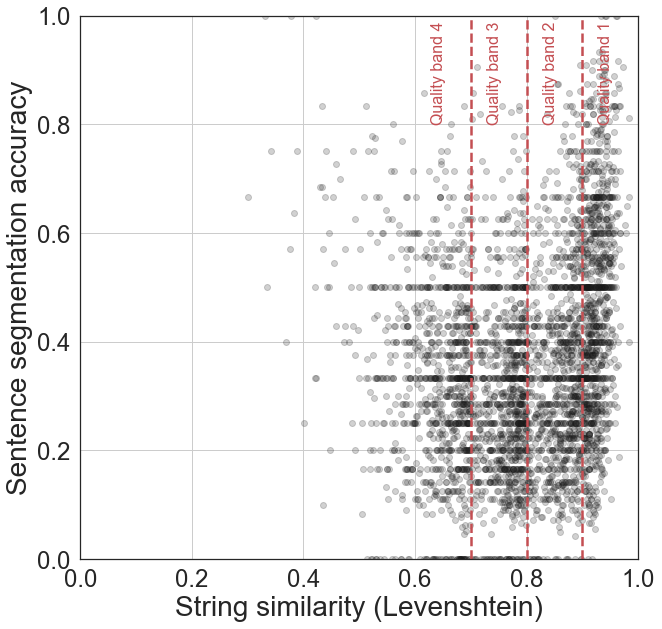

In [75]:
sent_filtered_df = sampledf[~sampledf['sent_acc'].isnull()]
sent_filtered_df = sent_filtered_df[sampledf['sent_acc'] != ""]

plt.figure(figsize=(10, 10))
plt.plot(sent_filtered_df['str_similarity'], sent_filtered_df['sent_acc'], 'ko', alpha=0.2)

plt.text(0.95, 0.8, 'Quality band 1', fontsize=16,
        rotation=90, rotation_mode='anchor', color='r')
plt.text(0.85, 0.8, 'Quality band 2', fontsize=16,
        rotation=90, rotation_mode='anchor', color='r')
plt.text(0.75, 0.8, 'Quality band 3', fontsize=16,
        rotation=90, rotation_mode='anchor', color='r')
plt.text(0.65, 0.8, 'Quality band 4', fontsize=16,
        rotation=90, rotation_mode='anchor', color='r')

plt.grid()
plt.xticks(size=24)
plt.yticks(size=24)
plt.xlabel("String similarity (Levenshtein)", size=28)
plt.ylabel("Sentence segmentation accuracy", size=28)
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
#plt.title("Words with {} letters or more".format(min_num_letters), size=32)
plt.axvline(0.9, 0, 1, c='r', ls='--')
plt.axvline(0.8, 0, 1, c='r', ls='--')
plt.axvline(0.7, 0, 1, c='r', ls='--')
# plt.title("Sentence segmentation")#, size=32)
# plt.show()
plt.savefig("figures/linguistic_analysis/sent_split.png", dpi=200)

In [76]:
# pos_filtered_df = sampledf[~sampledf['postag_acc'].isnull()]
# pos_filtered_df = pos_filtered_df[sampledf['postag_acc'] != ""]

# plt.figure(figsize=(10, 10))

# xbins = np.linspace(0, 1, 100)
# ybins = np.linspace(0, 1, 100)

# plt.hist2d(pos_filtered_df['str_similarity'], pos_filtered_df['postag_acc'], 
#            bins=[xbins, ybins],
#            vmax=7,
#            cmap=plt.cm.get_cmap('viridis', 100)
#           )
# plt.grid()
# plt.xticks(size=24)
# plt.yticks(size=24)
# plt.xlabel("Levenshtein similarity", size=28)
# plt.ylabel("Part-of-speech accuracy", size=28)
# plt.xlim(0.0, 1.0)
# plt.ylim(0.0, 1.0)

# cbar = plt.colorbar(aspect=20, orientation="vertical", fraction=0.05)
# cbar.set_label('#entries',size=28)
# cbar.ax.tick_params(labelsize=20) 
# # plt.show()
# plt.savefig("figures/linguistic_analysis/pos_tagging.png", dpi=300)

In [77]:
# # sampledf.plot(x='str_similarity', y='neriobtype_acc', style='o')
# ner_filtered_df = sampledf[~sampledf['neriobtype_acc'].isnull()]
# ner_filtered_df = ner_filtered_df[sampledf['neriobtype_acc'] != ""]

# plt.figure(figsize=(10, 10))

# xbins = np.linspace(0, 1, 100)
# ybins = np.linspace(0, 1, 100)

# plt.hist2d(ner_filtered_df['str_similarity'], ner_filtered_df['neriobtype_acc'], 
#            bins=[xbins, ybins],
#            vmax=7,
#            cmap=plt.cm.get_cmap('viridis', 100)
#           )
# plt.grid()
# plt.xticks(size=24)
# plt.yticks(size=24)
# plt.xlabel("Levenshtein similarity", size=28)
# plt.ylabel("Named entity recognition accuracy", size=28)
# plt.xlim(0.0, 1.0)
# plt.ylim(0.0, 1.0)

# cbar = plt.colorbar(aspect=20, orientation="vertical", fraction=0.05)
# cbar.set_label('#entries',size=28)
# cbar.ax.tick_params(labelsize=20) 
# plt.show()

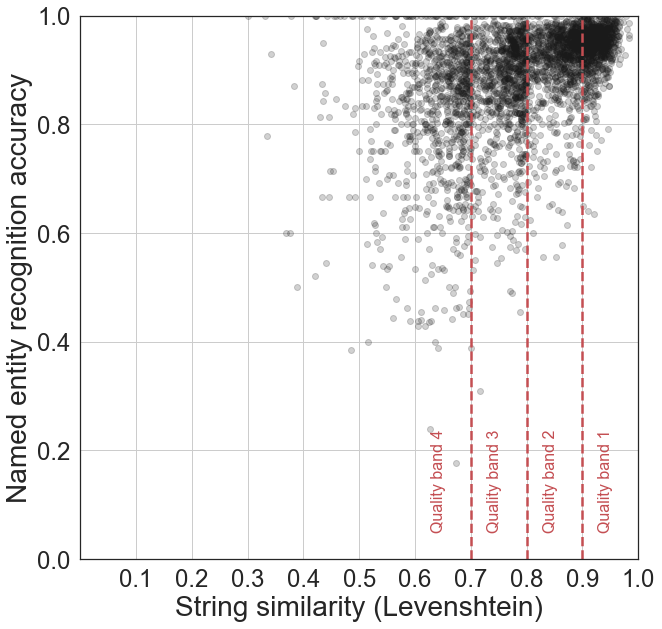

In [78]:
ner_filtered_df = sampledf[~sampledf['neriobtype_acc'].isnull()]
ner_filtered_df = ner_filtered_df[sampledf['neriobtype_acc'] != ""]

plt.figure(figsize=(10, 10))
plt.plot(ner_filtered_df['str_similarity'], ner_filtered_df['neriobtype_acc'], 'ko', alpha=0.2)

plt.text(0.95, 0.05, 'Quality band 1', fontsize=16,
        rotation=90, rotation_mode='anchor', color='r')
plt.text(0.85, 0.05, 'Quality band 2', fontsize=16,
        rotation=90, rotation_mode='anchor', color='r')
plt.text(0.75, 0.05, 'Quality band 3', fontsize=16,
        rotation=90, rotation_mode='anchor', color='r')
plt.text(0.65, 0.05, 'Quality band 4', fontsize=16,
        rotation=90, rotation_mode='anchor', color='r')

plt.grid()
plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], size=24)
plt.yticks(size=24)
plt.xlabel("String similarity (Levenshtein)", size=28)
plt.ylabel("Named entity recognition accuracy", size=28)
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
#plt.title("Words with {} letters or more".format(min_num_letters), size=32)
plt.axvline(0.9, 0, 1, c='r', ls='--')
plt.axvline(0.8, 0, 1, c='r', ls='--')
plt.axvline(0.7, 0, 1, c='r', ls='--')
# plt.title("Sentence segmentation")#, size=32)
# plt.show()
plt.savefig("figures/linguistic_analysis/ner_acc.png", dpi=200)

In [79]:
# # sampledf.plot(x='str_similarity', y='dependency_parsing', style='o')
# dep_filtered_df = sampledf[~sampledf['dependency_parsing'].isnull()]
# dep_filtered_df = dep_filtered_df[sampledf['dependency_parsing'] != ""]

# plt.figure(figsize=(10, 10))

# xbins = np.linspace(0, 1, 100)
# ybins = np.linspace(0, 1, 100)

# plt.hist2d(dep_filtered_df['str_similarity'], dep_filtered_df['dependency_parsing'], 
#            bins=[xbins, ybins],
#            vmax=7,
#            cmap=plt.cm.get_cmap('viridis', 100)
#           )
# plt.grid()
# plt.xticks(size=24)
# plt.yticks(size=24)
# plt.xlabel("Levenshtein similarity", size=28)
# plt.ylabel("Dependency parsing accuracy", size=28)
# plt.xlim(0.0, 1.0)
# plt.ylim(0.0, 1.0)

# cbar = plt.colorbar(aspect=20, orientation="vertical", fraction=0.05)
# cbar.set_label('#entries',size=28)
# cbar.ax.tick_params(labelsize=20) 
# # plt.show()
# plt.savefig("figures/linguistic_analysis/dep_parsing.png", dpi=300)

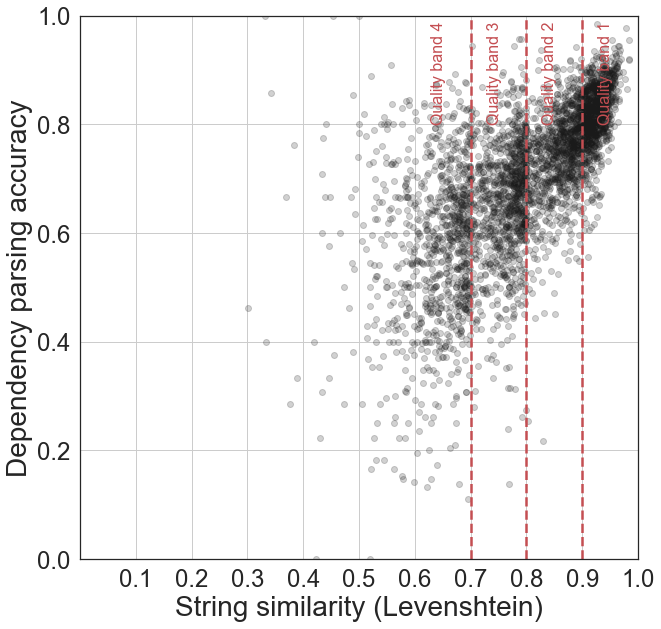

In [80]:
dep_filtered_df = sampledf[~sampledf['dependency_parsing'].isnull()]
dep_filtered_df = dep_filtered_df[sampledf['dependency_parsing'] != ""]

plt.figure(figsize=(10, 10))
plt.plot(dep_filtered_df['str_similarity'], dep_filtered_df['dependency_parsing'], 'ko', alpha=0.2)

plt.text(0.95, 0.8, 'Quality band 1', fontsize=16,
        rotation=90, rotation_mode='anchor', color='r')
plt.text(0.85, 0.8, 'Quality band 2', fontsize=16,
        rotation=90, rotation_mode='anchor', color='r')
plt.text(0.75, 0.8, 'Quality band 3', fontsize=16,
        rotation=90, rotation_mode='anchor', color='r')
plt.text(0.65, 0.8, 'Quality band 4', fontsize=16,
        rotation=90, rotation_mode='anchor', color='r')

plt.grid()
plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], size=24)
plt.yticks(size=24)
plt.xlabel("String similarity (Levenshtein)", size=28)
plt.ylabel("Dependency parsing accuracy", size=28)
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
#plt.title("Words with {} letters or more".format(min_num_letters), size=32)
plt.axvline(0.9, 0, 1, c='r', ls='--')
plt.axvline(0.8, 0, 1, c='r', ls='--')
plt.axvline(0.7, 0, 1, c='r', ls='--')
# plt.title("Sentence segmentation")#, size=32)
# plt.show()
plt.savefig("figures/linguistic_analysis/dep_parsing.png", dpi=200)

In [81]:
# sent_filtered_df = sampledf[~sampledf['sent_acc'].isnull()]
# sent_filtered_df = sent_filtered_df[sampledf['sent_acc'] != ""]

# plt.figure(figsize=(10, 10))

# xbins = np.linspace(0, 1, 75)
# ybins = np.linspace(0, 1, 75)

# plt.hist2d(sent_filtered_df['str_similarity'], sent_filtered_df['sent_acc'], 
#            bins=[xbins, ybins],
#            vmax=5,
#            cmap=plt.cm.get_cmap('viridis', 100)
#           )
# plt.grid()
# plt.xticks(size=24)
# plt.yticks(size=24)
# plt.xlabel("Levenshtein similarity", size=28)
# plt.ylabel("Sentence segmentation accuracy", size=28)
# plt.xlim(0.0, 1.0)
# plt.ylim(0.0, 1.0)

# cbar = plt.colorbar(aspect=20, orientation="vertical", fraction=0.05)
# cbar.set_label('#entries',size=28)
# cbar.ax.tick_params(labelsize=20) 
# # plt.show()
# plt.savefig("figures/linguistic_analysis/sentence_splitting.png", dpi=300)

In [82]:
sampledf_band1 = sampledf[sampledf['quality_band'] == 1]
sampledf_band2 = sampledf[sampledf['quality_band'] == 2]
sampledf_band3 = sampledf[sampledf['quality_band'] == 3]
sampledf_band4 = sampledf[sampledf['quality_band'] == 4]

In [83]:
# # Calculate average of dependency per band (NEIGHBOUR, LESS THAN 1 TOKEN DIFFERENCE):
print(sampledf_band1['dependency_parsing'].mean())
print(sampledf_band2['dependency_parsing'].mean())
print(sampledf_band3['dependency_parsing'].mean())
print(sampledf_band4['dependency_parsing'].mean())

0.8231645559541273
0.745747422670353
0.6581432531962675
0.5733143441117133


In [84]:
dfbands = [sampledf_band1, sampledf_band2, sampledf_band3, sampledf_band4]
for enttype in ['per', 'gpe', 'date']:
    print(enttype)
    for band in reversed(range(len(dfbands))):
        per_tp = dfbands[band]['ner_' + enttype + '_tp'].sum(axis=0)
        per_fp = dfbands[band]['ner_' + enttype + '_fp'].sum(axis=0)
        per_fn = dfbands[band]['ner_' + enttype + '_fn'].sum(axis=0)

        precision = per_tp / (per_tp + per_fp)
        recall = per_tp / (per_tp + per_fn)
        fscore = (2 * precision * recall) / (precision + recall)
        print("\tBand", str(band + 1) + ":", fscore)

per
	Band 4: 0.758222580212109
	Band 3: 0.7951013513513514
	Band 2: 0.8642524782520737
	Band 1: 0.9210642563457814
gpe
	Band 4: 0.7013241785188817
	Band 3: 0.750492264416315
	Band 2: 0.7935495968498031
	Band 1: 0.8508379888268156
date
	Band 4: 0.7324643078833024
	Band 3: 0.7721433400946586
	Band 2: 0.8225806451612903
	Band 1: 0.8826419837732831


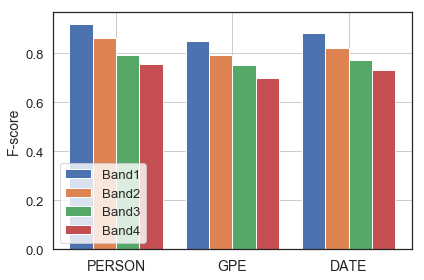

In [85]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = ['per', 'gpe', 'date']

bands_fscores = []
for band in range(len(dfbands)):
    entityfscores = []
    for enttype in labels:
        per_tp = dfbands[band]['ner_' + enttype + '_tp'].sum(axis=0)
        per_fp = dfbands[band]['ner_' + enttype + '_fp'].sum(axis=0)
        per_fn = dfbands[band]['ner_' + enttype + '_fn'].sum(axis=0)

        precision = per_tp / (per_tp + per_fp)
        recall = per_tp / (per_tp + per_fn)
        fscore = (2 * precision * recall) / (precision + recall)
        entityfscores.append(fscore)
#         print(fscore)
    bands_fscores.append(entityfscores)

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 0.30, bands_fscores[0], width, label='Band1')
rects2 = ax.bar(x - 0.10, bands_fscores[1], width, label='Band2')
rects3 = ax.bar(x + 0.10, bands_fscores[2], width, label='Band3')
rects4 = ax.bar(x + 0.30, bands_fscores[3], width, label='Band4')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F-score', size=14)
# ax.set_title('F-scores by named entity type and quality band')
ax.set_xticks(x)
ax.set_xticklabels(['PERSON', 'GPE', 'DATE'], size=14)
ax.legend()
plt.legend(loc='lower left')

fig.tight_layout()
plt.grid()
plt.savefig("figures/linguistic_analysis/ner_per_entity.png", dpi=200)